### Import Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import IsolationForest

%matplotlib inline

### Import Dataset

In [109]:
raw_data = pd.read_csv('./raw_sales.csv')
raw_data_houses = raw_data[(raw_data['bedrooms'] == 3) & (raw_data['propertyType'] == 'house')]
raw_data_houses.index = pd.to_datetime(raw_data_houses['datesold'])
raw_data_houses.drop(['datesold'], axis=1, inplace=True)


sales_quarter = raw_data_houses.resample('Q').mean()['price']

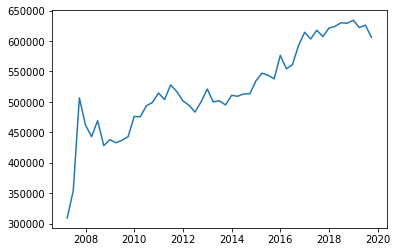

In [110]:
plt.figure()
plt.plot(sales_quarter)
plt.show()

In [111]:
def split_dataset(data):
    # split into standard weeks
    train, test = data[:-16], data[-16:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/4))
    test = np.array(np.split(test, len(test)/4))
    return train, test

def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

def plot_results(model):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, 6)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    predictions= predictions.reshape(predictions.shape[0],predictions.shape[1])
    
    preds = predictions.flatten()
    preds = preds.reshape(preds.shape[0], 1)
    preds = scaler.inverse_transform(preds).flatten()
    
    actual = series[-predictions.flatten().shape[0]:].flatten()
    actual = actual.reshape(actual.shape[0], 1)
    actual = scaler.inverse_transform(actual).flatten()
    
    
    mse = mean_squared_error(actual, preds)
    
    print(f'MSE - {mse}')

    plt.figure(figsize=(15,5))
    plt.plot(preds, label="Predictions")
    plt.plot(actual, label="Actual Values")
    plt.legend()
    plt.show()
    
    return preds, actual

### Data preprocessing

In [112]:
series = sales_quarter.values.reshape(-1,1)
input_shape = 4
output_shape = 4

# define min max scaler
scaler = MinMaxScaler()
# transform data
series = scaler.fit_transform(series)

train, test = split_dataset(series.astype(np.float32)[-48:])
train_x, train_y = to_supervised(train, input_shape, output_shape)
test_x, test_y = to_supervised(test, input_shape, output_shape)

### Stacked Bidirectional LSTM

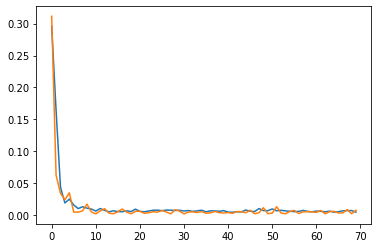

MSE - 583037257.8128653


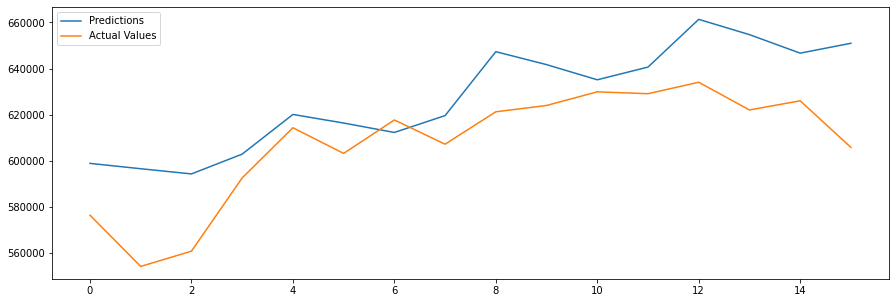

In [113]:
# define parameters
verbose, epochs, batch_size = 0, 70, 4
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
stacked_lstm = Sequential()
stacked_lstm.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
stacked_lstm.add(Dense(200, activation='relu'))
stacked_lstm.add(Dropout(0.4))
stacked_lstm.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(n_outputs))
stacked_lstm.compile(loss='mse', optimizer='adam')

# fit network
stacked_lstm_history = stacked_lstm.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

plt.plot(stacked_lstm_history.history['loss'])
plt.plot(stacked_lstm_history.history['val_loss'])
plt.show()

# Plot and compare results
preds, actual = plot_results(stacked_lstm)

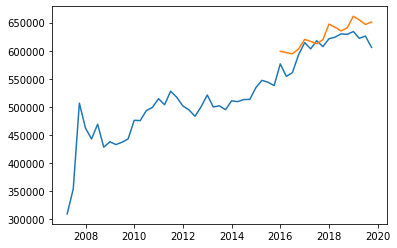

In [119]:
summary = pd.DataFrame(sales_quarter)
summary['predictions'] = np.nan
summary['predictions'][-16:] = preds

plt.figure()
plt.plot(summary)
plt.show()

### Enseble and Confidence Interval Inference

In [120]:
from sklearn.metrics import mean_absolute_error

def fit_model(X_train, y_train):
    # define parameters
    verbose, epochs, batch_size = 0, 70, 4
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # define model
    stacked_lstm = Sequential()
    stacked_lstm.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
    stacked_lstm.add(Dense(200, activation='relu'))
    stacked_lstm.add(Dropout(0.4))
    stacked_lstm.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
    stacked_lstm.add(Dropout(0.2))
    stacked_lstm.add(Dense(n_outputs))
    stacked_lstm.compile(loss='mse', optimizer='adam')

    # fit network
    stacked_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
    return stacked_lstm

# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        # define and fit the model on the training set
        model = fit_model(X_train, y_train)
        # evaluate model on the test set
        yhat = model.predict(X_test)
        mae = mean_absolute_error(y_test, yhat)
        print(f'{i} - {mae}')
        # store the model
        ensemble.append(model)
    return ensemble


n_members = 10
ensemble = fit_ensemble(n_members, train_x, test_x, train_y, test_y)

0 - 0.17861148715019226
1 - 0.22817492485046387
2 - 0.23754116892814636
3 - 0.2243255078792572
4 - 0.20633363723754883
5 - 0.18556979298591614
6 - 0.27649834752082825
7 - 0.23939117789268494
8 - 0.24443215131759644
9 - 0.25621193647384644


In [121]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
    # make predictions
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.asarray(yhat)
    # calculate 95% gaussian prediction interval
    interval = 1.96 * yhat.std()
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

y_hats = []
for model in ensemble:
    pred = model.predict(test_x[0].reshape(1,input_shape,1))
    y_hats.append(pred)

predictions = []
means, stds, lowers, uppers = [], [], [], []

for i in range(output_shape):
    mean = np.asarray(y_hats)[:,0,i].mean()
    std = np.asarray(y_hats)[:,0,i].std()
    interval = 1.96 * std

    predictions.append((
      mean,
      std,
      mean + interval,
      mean - interval))

       mean       std     upper     lower    actual
0  0.693524  0.030669  0.753635  0.633413  0.939315
1  0.686131  0.026395  0.737865  0.634397  0.905083
2  0.690024  0.025985  0.740955  0.639094  0.949690
3  0.694524  0.027734  0.748883  0.640165  0.917393


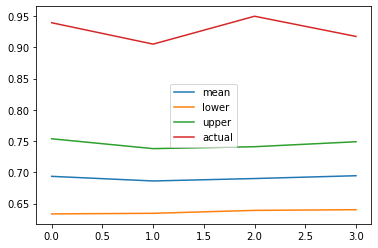

In [122]:
pred_df = pd.DataFrame(data=predictions, columns=['mean', 'std', 'upper', 'lower'])
pred_df['actual'] = test_y[0]

print(pred_df)

# plt.fill_between(pred_df['mean'], pred_df['lower'], pred_df['upper'])
plt.plot(pred_df['mean'], label='mean')
plt.plot(pred_df['lower'], label='lower')
plt.plot(pred_df['upper'], label='upper')
plt.plot(pred_df['actual'], label='actual')
plt.legend()
plt.show()
